# Case Study 2

Alban Dietrich, UNI: ad4017, 12 March 2023.

We first import some libraries.

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

Let us define the parameters that we will use.

In [2]:
# Set parameters
S0 = 1900
K = 2000
B = 2200
r = 0.0025
q = 0.015
T = 0.5
sig = 0.25
v = 0.31
theta = -0.25
Y = 0.4

# Parameter for g1 & g2 functions
alpha = Y

We define the minimum and maximum values of x to determine the interval we want to explore.

In [3]:
S_max = B               
S_min = 1
x_max = np.log(S_max)  
x_min = np.log(S_min)

We do the following changes of variables: $x = ln(S)$ and $\tau = T-t$.

Before starting the discretization of the PIDE, we look into the evalutaion of the integral term (a detailed explanation of the explicit-implicit finite difference scheme is given in the report).

As the Levy process $k(y)$ is singular at $y = 0$, we will divide the evaluation of the integral in 2 domains: $\left|y\right| > \epsilon$ and $\left|y\right| <= \epsilon$.
An obvious choice is $\epsilon = \Delta x$.

Let us define the discretization parameters:

In [4]:
N = 100
M = 100

Delta_x = (x_max-x_min)/N
Delta_tau = (T-0)/M

Let us initialize the value of a derivative security and other functions we will use after.

In [5]:
w = np.zeros((N+1, M+1))
l = np.zeros((N+1, M+2))
d = np.zeros((N+1, M+2))
u = np.zeros((N+1, M+2))
R = np.zeros((N+1, M+1))

Let us define the value of the $x_i$ and $\tau$ variables we will use.

In [6]:
array_x = np.zeros((N+1, M+1))
array_t = np.zeros((N+1, M+1))

for i in range(N+1):
    for j in range(M+1):
        array_x[i][j] = x_min + i*Delta_x
        array_t[i][j] = j*Delta_tau

Let us apply the initial condition.

In [7]:
for i in range(N+1):
    x = x_min + i*Delta_x
    w[i][0] = max((np.exp(x)-K),0)

And the boudary conditions.

In [8]:
for i in range(M+1):
    w[0][i] = 0
    w[N][i] = 0

Let us define some constants:

In [9]:
lambda_p = (theta**2/sig**4+2/(sig**2*v))**(1/2)-theta/sig**2
lambda_n = (theta**2/sig**4+2/(sig**2*v))**(1/2)+theta/sig**2

Let us define the $g_1$ and $g_2$ functions.

In [10]:
def g1(xi):
    return integrate.quad(lambda z: np.exp(-z)/z**alpha,xi,np.inf)[0]

In [11]:
def g2(xi):
    return integrate.quad(lambda z: np.exp(-z)/z**(alpha+1),xi,np.inf)[0]

To speed up the calculation, we precalculate the following values:

In [12]:
g1_lambda_n_Delta_x = [0] 
g1_lambda_p_Delta_x = [0] 
g2_lambda_n_Delta_x = [0] 
g2_lambda_p_Delta_x = [0] 
g2_lambda_n_plus_Delta_x = [0] 
g2_lambda_p_minus_Delta_x = [0] 

for k in range(1, N+1):
    g1_lambda_n_Delta_x.append(g1(k*lambda_n*Delta_x))
    g1_lambda_p_Delta_x.append(g1(k*lambda_p*Delta_x))
    g2_lambda_n_Delta_x.append(g2(k*lambda_n*Delta_x))
    g2_lambda_p_Delta_x.append(g2(k*lambda_p*Delta_x))
    g2_lambda_n_plus_Delta_x.append(g2(k*(lambda_n+1)*Delta_x))
    g2_lambda_p_minus_Delta_x.append(g2(k*(lambda_p-1)*Delta_x))

Let us define more functions $\sigma^2(\epsilon)$ and $\omega(\epsilon)$:

In [13]:
def sigma2(eps):
    return 1/v*lambda_p**(Y-2)*(-(lambda_p*eps)**(1-Y)*np.exp(-lambda_p*eps)+(1-Y)*(g1(0)-g1(lambda_p*eps)))\
+1/v*lambda_n**(Y-2)*(-(lambda_n*eps)**(1-Y)*np.exp(-lambda_n*eps)+(1-Y)*(g1(0)-g1(lambda_n*eps)))

In [14]:
def omega(eps):
    return lambda_p**Y/v*g2(lambda_p*eps)-(lambda_p-1)**Y/v*g2((lambda_p-1)*eps)\
+ lambda_n**Y/v*g2(lambda_n*eps)-(lambda_n+1)**Y/v*g2((lambda_n+1)*eps)

Let us define more constants ($B_l$ and $B_u$):

In [15]:
Bl = sigma2(Delta_x)*Delta_tau/(2*Delta_x**2)-(r-q+omega(Delta_x)-1/2*sigma2(Delta_x))*Delta_tau/(2*Delta_x)
Bu = sigma2(Delta_x)*Delta_tau/(2*Delta_x**2)+(r-q+omega(Delta_x)-1/2*sigma2(Delta_x))*Delta_tau/(2*Delta_x)

We can assign these values to the elements $l_{i,j+1}$ and $u_{i,j+1}$:

In [16]:
l = [[-Bl]*(M+2)]*(N+1)
u = [[-Bu]*(M+2)]*(N+1)

We can compute the $d_{i,j+1}$ elements:

In [17]:
for i in range(1,N+1):
    for j in range(M+1):
        d[i][j+1] = 1+r*Delta_tau+Bl+Bu+Delta_tau/v*(lambda_n**Y*g2_lambda_n_Delta_x[i]+lambda_p**Y*g2_lambda_p_Delta_x[N-i])

We define the $R_{i,j}$ elements. To do so, we divide the calculation into 5 terms that we sum at the end.

In [18]:
def R(i,j):
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    term_5 = 0

    for k in range(1, i):
        sum_1 += lambda_n**Y*(w[i-k][j]-w[i][j]-k*(w[i-k-1][j]-w[i-k][j]))*(g2_lambda_n_Delta_x[k]-g2_lambda_n_Delta_x[k+1])

    for k in range(1, i):
        sum_2 += (w[i-k-1][j]-w[i-k][j])/(lambda_n**(1-Y)*Delta_x)*(g1_lambda_n_Delta_x[k]-g1_lambda_n_Delta_x[k+1])

    for k in range(1, N-i):
        sum_3 += lambda_p**Y*(w[i+k][j]-w[i][j]-k*(w[i+k+1][j]-w[i+k][j]))*(g2_lambda_p_Delta_x[k]-g2_lambda_p_Delta_x[k+1])

    for k in range(1, N-i):
        sum_4 += (w[i+k+1][j]-w[i+k][j])/(lambda_p**(1-Y)*Delta_x)*(g1_lambda_p_Delta_x[k]-g1_lambda_p_Delta_x[k+1])

    xi = x_min + i*Delta_x
    term_5 = K*lambda_n**Y*g2_lambda_n_Delta_x[i]-np.exp(xi)*(lambda_n+1)**Y*g2_lambda_n_plus_Delta_x[i]

    return sum_1+sum_2+sum_3+sum_4+term_5

Accoding to leture 5, on slide 28, we have the following difference equation below. We assume that we know at a time $\tau_j$, $w_{i,j}$. We thus solve a linear system to find $w_{i,j+1}$ for all $i$. We choose m iterations to updates the values of $w$ at each cycle.

In [19]:
start_time = time.time()

# Number of iterations

m = 5
for itr in range(m):
    for j in range(0,M):
        for i in range(1,N):
            w[i][j+1] = (w[i][j]+Delta_tau/v*R(i,j)-l[i][j+1]* w[i-1][j+1]-u[i][j+1]* w[i+1][j+1])/d[i][j+1]
            
elapsed_time = time.time() - start_time

print('The execution time was %0.7f seconds' % elapsed_time)

The execution time was 6.2168341 seconds


We plot the results.

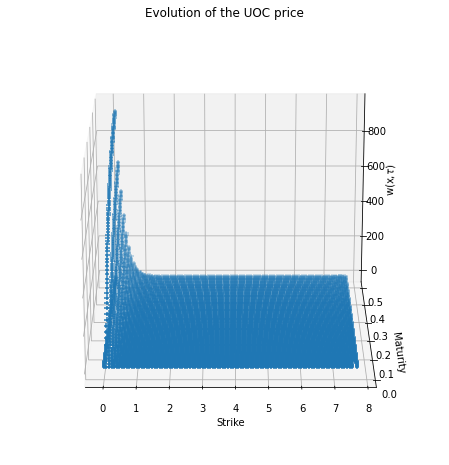

In [20]:
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')

m = '+'

ax.scatter(np.array(array_x), np.array(array_t), np.array(w), marker=m)

ax.view_init(20, 270)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel(r'w(x,$\tau$)')
plt.title('Evolution of the UOC price')

fig.savefig('plot.png', bbox_inches='tight')

plt.show()

Let us find the UOC option premium at S0 and maturity T = 0.5. To do so we use an interpolation function. We find:

In [21]:
UOC = np.interp(np.log(S0), np.array(array_x)[:,M], w[:,M])
print(UOC)

1.7449607702117078


By using an online calculator of the Black Scholes (BS) model, we find a value of 3.97. As we are using a different model, it is normal that we don't get the exact same value but we will see if we can get closer to this value.

To improve our result we could increase the discretization N/M or reduce the interval $\left[x_\text{min}, x_\text{max}\right]$  by taking a bigger value for $x_\text{min}$. By doing so, for the same discretization N, we have a better resolution.

Let us take $S_\text{min} = K/2$ (before we had $S_\text{min} = 1$) with $N = 100$ and $M = 100$

So let us reinitialize our model and run it again for $S_\text{min} = K/2$.

In [22]:
S_max = B               
S_min = K/2
x_max = np.log(S_max)  
x_min = np.log(S_min)

N = 100
M = 100

Delta_x = (x_max-x_min)/N
Delta_tau = (T-0)/M

w = np.zeros((N+1, M+1))
l = np.zeros((N+1, M+2))
d = np.zeros((N+1, M+2))
u = np.zeros((N+1, M+2))
R = np.zeros((N+1, M+1))

array_x = np.zeros((N+1, M+1))
array_t = np.zeros((N+1, M+1))

for i in range(N+1):
    for j in range(M+1):
        array_x[i][j] = x_min + i*Delta_x
        array_t[i][j] = j*Delta_tau
        
for i in range(N+1):
    x = x_min + i*Delta_x
    w[i][0] = max((np.exp(x)-K),0)
    
for i in range(M+1):
    w[0][i] = 0
    w[N][i] = 0
    
lambda_p = (theta**2/sig**4+2/(sig**2*v))**(1/2)-theta/sig**2
lambda_n = (theta**2/sig**4+2/(sig**2*v))**(1/2)+theta/sig**2

g1_lambda_n_Delta_x = [0] 
g1_lambda_p_Delta_x = [0] 
g2_lambda_n_Delta_x = [0] 
g2_lambda_p_Delta_x = [0] 
g2_lambda_n_plus_Delta_x = [0] 
g2_lambda_p_minus_Delta_x = [0] 

for k in range(1, N+1):
    g1_lambda_n_Delta_x.append(g1(k*lambda_n*Delta_x))
    g1_lambda_p_Delta_x.append(g1(k*lambda_p*Delta_x))
    g2_lambda_n_Delta_x.append(g2(k*lambda_n*Delta_x))
    g2_lambda_p_Delta_x.append(g2(k*lambda_p*Delta_x))
    g2_lambda_n_plus_Delta_x.append(g2(k*(lambda_n+1)*Delta_x))
    g2_lambda_p_minus_Delta_x.append(g2(k*(lambda_p-1)*Delta_x))
    
Bl = sigma2(Delta_x)*Delta_tau/(2*Delta_x**2)-(r-q+omega(Delta_x)-1/2*sigma2(Delta_x))*Delta_tau/(2*Delta_x)
Bu = sigma2(Delta_x)*Delta_tau/(2*Delta_x**2)+(r-q+omega(Delta_x)-1/2*sigma2(Delta_x))*Delta_tau/(2*Delta_x)

l = [[-Bl]*(M+2)]*(N+1)
u = [[-Bu]*(M+2)]*(N+1)

for i in range(1,N+1):
    for j in range(M+1):
        d[i][j+1] = 1+r*Delta_tau+Bl+Bu+Delta_tau/v*(lambda_n**Y*g2_lambda_n_Delta_x[i]+lambda_p**Y*g2_lambda_p_Delta_x[N-i])

In [23]:
def R(i,j):
    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0
    term_5 = 0

    for k in range(1, i):
        sum_1 += lambda_n**Y*(w[i-k][j]-w[i][j]-k*(w[i-k-1][j]-w[i-k][j]))*(g2_lambda_n_Delta_x[k]-g2_lambda_n_Delta_x[k+1])

    for k in range(1, i):
        sum_2 += (w[i-k-1][j]-w[i-k][j])/(lambda_n**(1-Y)*Delta_x)*(g1_lambda_n_Delta_x[k]-g1_lambda_n_Delta_x[k+1])

    for k in range(1, N-i):
        sum_3 += lambda_p**Y*(w[i+k][j]-w[i][j]-k*(w[i+k+1][j]-w[i+k][j]))*(g2_lambda_p_Delta_x[k]-g2_lambda_p_Delta_x[k+1])

    for k in range(1, N-i):
        sum_4 += (w[i+k+1][j]-w[i+k][j])/(lambda_p**(1-Y)*Delta_x)*(g1_lambda_p_Delta_x[k]-g1_lambda_p_Delta_x[k+1])

    xi = x_min + i*Delta_x
    term_5 = K*lambda_n**Y*g2_lambda_n_Delta_x[i]-np.exp(xi)*(lambda_n+1)**Y*g2_lambda_n_plus_Delta_x[i]

    return sum_1+sum_2+sum_3+sum_4+term_5

We calculate the new $w$ function.

In [24]:
start_time = time.time()

# Number of iterations

m = 5
for itr in range(m):
    for j in range(0,M):
        for i in range(1,N):
            w[i][j+1] = (w[i][j]+Delta_tau/v*R(i,j)-l[i][j+1]* w[i-1][j+1]-u[i][j+1]* w[i+1][j+1])/d[i][j+1]
            
elapsed_time = time.time() - start_time

print('The execution time was %0.7f seconds' % elapsed_time)

The execution time was 6.2010911 seconds


We obtain the following result:

In [25]:
UOC = np.interp(np.log(S0), np.array(array_x)[:,M], w[:,M])
print(UOC)

4.139740590658877


We are thus closer to the result obtain with with the BS model. Thus the choice of the parameters and the resolution are very important.

To solve this problem, we could also use another method. For example by using the tridiagonal solver.

Let us write a code using this solver and compare the result with what we obtained before. 

First we define the tridiagonal solver function.

In [26]:
def diagSolver(l, d, u, B, n):
    l_ = np.zeros(n+1)
    d_ = np.zeros(n+1)
    u_ = np.zeros(n+1)
    for i in range(1,n+1):
        l_[i] = l[i]
        d_[i] = d[i]
        u_[i] = u[i]
    for i in range(n-1, 0, -1):
        x = u_[i]/d_[i+1]
        d_[i] = d_[i] - x * l_[i+1]
        B[i] = B[i] - x * B[i+1]
    B[1] = B[1]/d_[1]
    i_start = 1
    for i in range(i_start+1, n+1):
        B[i] = (B[i] - l_[i] * B[i-1])/d_[i]

Now let us solve our problem.

We define the discretization parameters.

In [27]:
N = 200
M = 20

We pre-calculate some values as before to speed-up the calculation.

In [28]:
g1_lambda_n_Delta_x = [0] 
g1_lambda_p_Delta_x = [0] 
g2_lambda_n_Delta_x = [0] 
g2_lambda_p_Delta_x = [0] 
g2_lambda_n_plus_Delta_x = [0] 
g2_lambda_p_minus_Delta_x = [0] 

for k in range(1, N+1):
    g1_lambda_n_Delta_x.append(g1(k*lambda_n*Delta_x))
    g1_lambda_p_Delta_x.append(g1(k*lambda_p*Delta_x))
    g2_lambda_n_Delta_x.append(g2(k*lambda_n*Delta_x))
    g2_lambda_p_Delta_x.append(g2(k*lambda_p*Delta_x))
    g2_lambda_n_plus_Delta_x.append(g2(k*(lambda_n+1)*Delta_x))
    g2_lambda_p_minus_Delta_x.append(g2(k*(lambda_p-1)*Delta_x))

We initialize the variables.

In [29]:
x = np.zeros(N+1)
W = np.zeros(N+1)

A = np.zeros(M)
r_ = np.zeros(M)
q_ = np.zeros(M)

L = np.zeros(N)
U = np.zeros(N)
D = np.zeros(N)
B = np.zeros(N)

B_n = Delta_tau*(1-np.exp(-lambda_n*Delta_x))/(v*lambda_n*Delta_x)
B_p = Delta_tau*(1-np.exp(-lambda_p*Delta_x))/(v*lambda_p*Delta_x)

We put the initial and boundary conditions.

In [30]:
for i in range(N+1):
    x[i] = np.log(S_min)+i*Delta_x
    if i == N:
        W[i] = 0
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0

We have the main loop.

In [31]:
start_time = time.time()

for j in range(M-1, -1, -1):
    q_[j] = q
    r_[j] = r
    A[j] = (r_[j]-q_[j]+np.log(1-theta*v-sig*sig*v/2)/v)*Delta_tau/Delta_x
    for i in range(1, N):
        B[i] = W[i]
    for i in range(1, N):
        if i == N-1:
            L[i] = A[j] - B_n
            D[i] = 1 + r_[j]*Delta_tau + B_p + B_n + Delta_tau*((lambda_n**Y*g2(i*Delta_x*lambda_n)+lambda_p**Y*g2((N-i)*Delta_x*lambda_p)))/v
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_lambda_n_Delta_x[k]-g2_lambda_n_Delta_x[k+1])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Delta_x)*(g2_lambda_n_Delta_x[k]-g2_lambda_n_Delta_x[k+1])
        elif i == 1:
            D[i] = 1 + r_[j]*Delta_tau + B_p + B_n + Delta_tau*((lambda_n**Y*g2(i*Delta_x*lambda_n)+lambda_p**Y*g2((N-i)*Delta_x*lambda_p)))/v
            U[i] = -A[j] - B_p
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g1_lambda_p_Delta_x[k]-g1_lambda_p_Delta_x[k+1])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Delta_x)*(g1_lambda_p_Delta_x[k]-g1_lambda_p_Delta_x[k+1])
        else:
            L[i] =  A[j] - B_n
            D[i] =  1 + r_[j]*Delta_tau + B_p + B_n + Delta_tau*((lambda_n**Y*g2(i*Delta_x*lambda_n)+lambda_p**Y*g2((N-i)*Delta_x*lambda_p)))/v
            U[i] = -A[j] - B_p
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_lambda_p_Delta_x[k]-g2_lambda_p_Delta_x[k+1])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Delta_x)*(g1_lambda_p_Delta_x[k]-g1_lambda_p_Delta_x[k+1])
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_lambda_n_Delta_x[k]-g2_lambda_n_Delta_x[k+1])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Delta_x)*(g1_lambda_n_Delta_x[k]-g1_lambda_n_Delta_x[k+1])
        B[i] += K*lambda_n**Y*g2(i*Delta_x*lambda_n) -np.exp(x[i])*(lambda_n+1)**Y*g2(i*Delta_x*(lambda_n+1))
    diagSolver(L,D,U,W,N-1)
    
elapsed_time = time.time() - start_time
print('The execution time was %0.7f seconds' % elapsed_time)

The execution time was 1.4833007 seconds


Now let us calculate the option premium.

In [32]:
UOC = np.interp(np.log(S0), x, W)
print("The UOC premium for strike %s the option premium is %6.4f" % (2000,UOC))

The UOC premium for strike 2000 the option premium is 3.2507
